In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
import pandas as pd
import numpy as np
import string

from time import time
from sklearn import preprocessing, model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

In [51]:
df = pd.read_csv('yelp1.csv')
df = df[['User_id','Product_id','Date','Rating','Review','Label']]
df.head()

,User_id,Product_id,Date,Rating,Review,Label
0,923,0,12/8/2014,3,The food at snack is a selection of popular Gr...,-1
1,924,0,5/16/2013,3,This little place in Soho is wonderful. I had ...,-1
2,925,0,7/1/2013,4,ordered lunch for 15 from Snack last Friday. Â...,-1
3,926,0,7/28/2011,4,This is a beautiful quaint little restaurant o...,-1
4,927,0,11/1/2010,4,Snack is great place for a Â casual sit down l...,-1


# 1. Overview

In [52]:
# Number of unique customers
df.User_id.nunique()

4760

In [53]:
# Number of unique restaurants
df.Product_id.nunique()

16

# 2. Feature Engineering

## 2.1 Review based Features

In [54]:
# Day of week
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_week'] = df['Date'].apply(lambda x: x.weekday())

# Number of chars in the review;
df['char_count'] = df['Review'].apply(len)

# Number of words in the review;
df['word_count'] = df['Review'].apply(lambda x: len(x.split()))

# Word Density
df['word_density'] = df['char_count'] / (df['word_count']+1)

# Percentage of exclamation
df['exclamation_percent'] = df['Review'].apply(lambda x: len([i for i in x.split() if i == '!'])/len(x.split())) 

# Percentage of punctuation
df['punctuation_percent'] = df['Review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))/len(x.split())) 

# Percentage of title words
df['title_word_percent'] = df['Review'].apply(lambda x: len([i for i in x.split() if i.istitle()])/len(x.split()))
                                                   
# Percentage of upper case words                                                   
df['upper_case_word_percent'] = df['Review'].apply(lambda x: len([i for i in x.split() if i.isupper()])/len(x.split()))
                                                   
# Percentage of first person                                                   
df['first_person_percent'] = df['Review'].apply(lambda x: len([i for i in x.split() if (i == 'I' or i == 'i')])/len(x.split()))             

###  Polarity score

In [55]:
# Calculate polarity score of each review text
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

def text_clean(text):
    # Convert to lower case
    lower_text = text.lower()
    
    # Remove punctuation
    lower_text = re.sub("[()\"\'\?\.\,\%\/\!\:\;\-\=\#\&_]", " ", lower_text)
    
    # Tokenize text
    token_text = word_tokenize(lower_text)
    
    # Remove stopwords and words with length <=2
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in token_text if (not w in stop_words) and (len(w)>2)]
    
    text = " ".join(filtered_text).strip()
    
    return text

df['review_text_token'] = df['Review'].apply(text_clean)

[nltk_data] Downloading package punkt to C:\Users\Asif
[nltk_data]     Iqbal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Asif
[nltk_data]     Iqbal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
from textblob import TextBlob
def text_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['text_polarity'] = df['review_text_token'].apply(text_polarity)

## 2.2 User based Features

In [57]:
def intragroup(cands, taggings, features):
    dupers = []
    for thisgrp in cands:
        grpmask = taggings == thisgrp
        revcount = grpmask.sum()
        if revcount > 1:
            simgrp = features[grpmask.values]
            if simgrp.nunique() != len(simgrp):
                dupers.append(thisgrp)
    return dupers

In [58]:
# Total number of reviews        
df['user_no_of_review'] = df.groupby('User_id')['User_id'].transform('size')

# Max number of reviews per day
user_max_no_reviews = df.groupby(['User_id','Date'], as_index = False).agg({'Review':'count'}).drop('Date',axis = 1)\
                 .groupby(['User_id'],as_index = False).agg({'Review':'max'}).rename(columns = {'Review':'user_max_no_review_per_day'})

df = pd.merge(df, user_max_no_reviews, how = 'inner', on = 'User_id')

# Average rating
df['user_avg_rating'] = df.groupby('User_id')['Rating'].transform('mean')

# Rating deviation
df['user_rating_std'] = df.groupby('User_id')['Rating'].transform('std')

# Average number of words
df['user_avg_no_words'] = df.groupby('User_id')['word_count'].transform('mean')

# Whether user has submitted exact same review text twice
duplicating_users = intragroup(df['User_id'].unique(), df['User_id'], df['Review']) # slow
df['user_has_dup_text'] = df['User_id'].apply(lambda x: x in duplicating_users).astype(int)

## 2.3 Restaurant based Features

In [59]:
# Total number of reviews        
df['prod_no_of_review'] = df.groupby('Product_id')['Product_id'].transform('size')

# Max number of reviews received per day
prod_max_no_reviews = df.groupby(['Product_id','Date'], as_index = False).agg({'Review':'count'}).drop('Date',axis = 1)\
                 .groupby(['Product_id'],as_index = False).agg({'Review':'max'}).rename(columns = {'Review':'prod_max_no_review_per_day'})

df = pd.merge(df,prod_max_no_reviews, how = 'inner', on = 'Product_id')

# Average rating
df['prod_avg_rating'] = df.groupby('Product_id')['Rating'].transform('mean')

# Rating deviation
df['prod_rating_std'] = df.groupby('Product_id')['Rating'].transform('std')

# Average number of words
df['prod_avg_no_words'] = df.groupby('Product_id')['word_count'].transform('mean')

# Whether restaurant has received exact same review text twice
duplicating_prods = intragroup(df['Product_id'].unique(), df['Product_id'], df['Review'])
df['prod_has_dup_text'] = df['Product_id'].apply(lambda x: x in duplicating_prods).astype(int)

# 3. EDA for New Features

## 3.1 User based Features

In [60]:
# Plot 4: User Based Features ——Have fake reviews/ no fake reviews
user_fake = df[df.Label == 1]['User_id'].drop_duplicates().tolist()
df_user = df[['User_id','user_no_of_review','user_max_no_review_per_day','user_avg_rating','user_avg_no_words']].drop_duplicates()
df_user_fake = df_user[df_user.User_id.isin(user_fake)].drop(['User_id'] ,axis = 1)
df_user_genuine = df_user.drop(df_user_fake.index).drop(['User_id'], axis = 1)

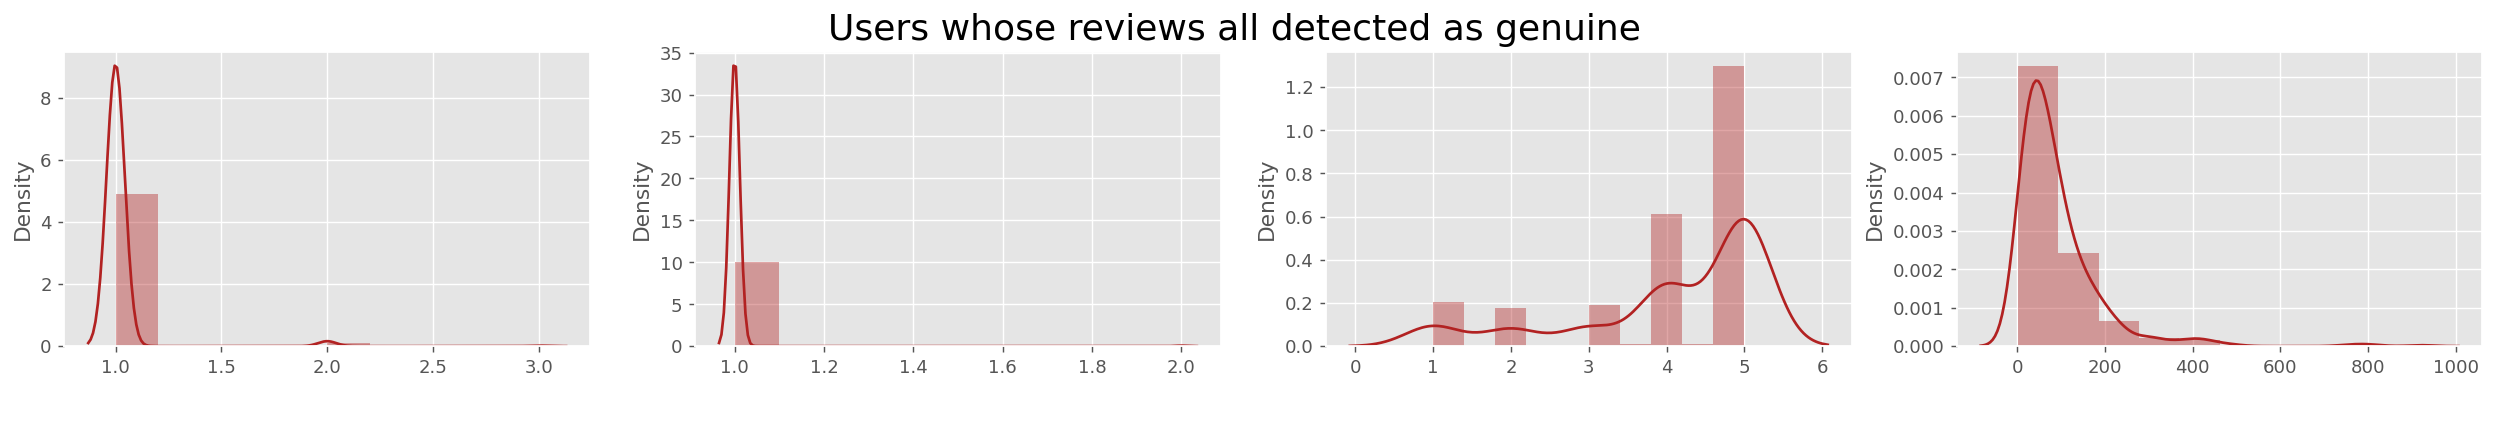

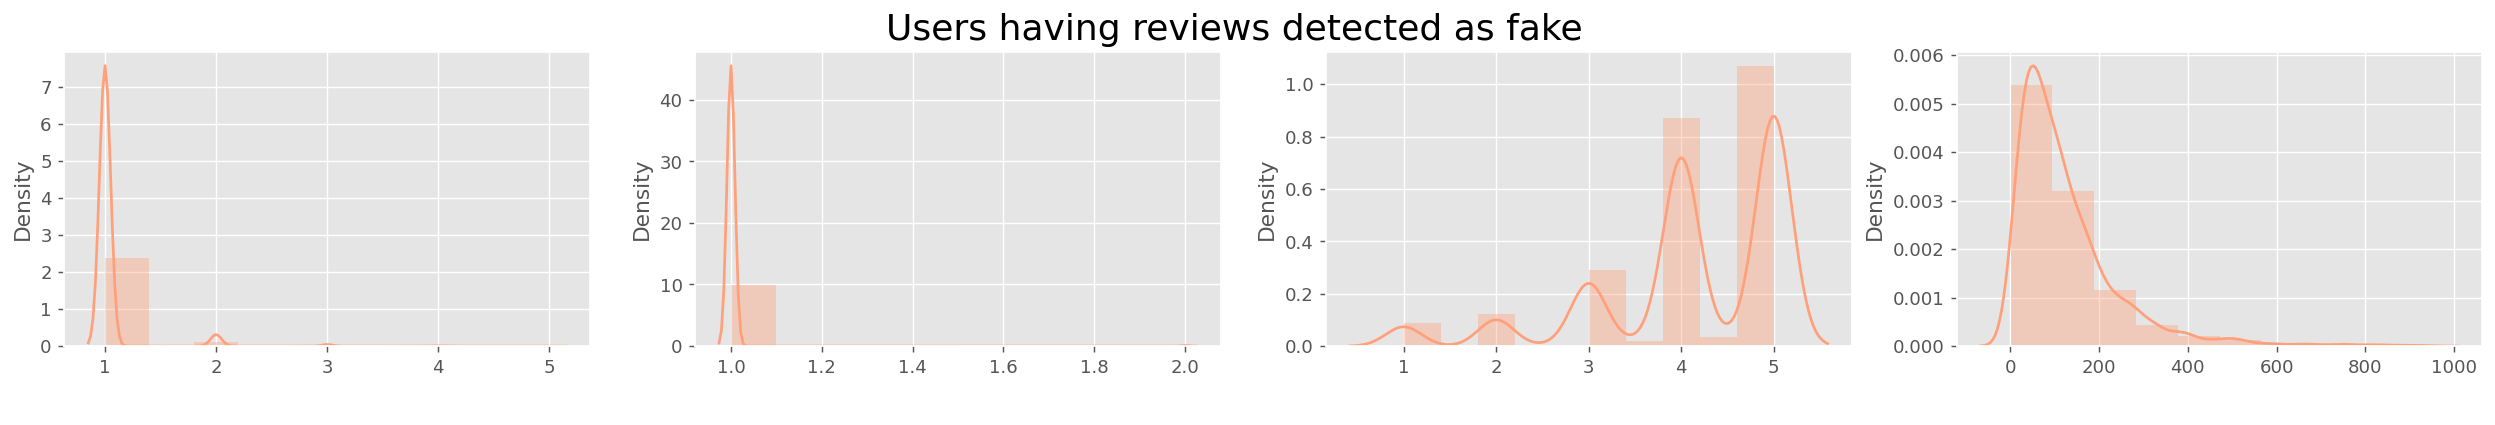

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def displot_user(df,color,title):
    plt.style.use('ggplot')
    #sns.set_style('darkgrid', {'figure.facecolor': 'black'})
    fig,axes=plt.subplots(1,4, figsize=(24, 3), dpi = 130)
    fig.suptitle(title,fontsize=20)
    sns.distplot(df.user_no_of_review, kde=True, bins=10,ax=axes[0],color=color)
    #axes[0].tick_params(colors='white') 
    axes[0].set_xlabel('Total number of reviews',fontsize=16, color = 'white')
    sns.distplot(df.user_max_no_review_per_day,kde= True, bins=10,ax=axes[1],color=color)
    #axes[1].tick_params(colors='white') 
    axes[1].set_xlabel('Max number of reviews per day',fontsize=16, color = 'white')
    sns.distplot(df.user_avg_rating,kde=True,bins=10,ax=axes[2], color=color)
    #axes[2].tick_params(colors='white') 
    axes[2].set_xlabel('Average rating',fontsize = 16, color = 'white')
    sns.distplot(df.user_avg_no_words,kde=True,bins=10,ax=axes[3], color=color)
    #axes[3].tick_params(colors='white') 
    axes[3].set_xlabel('Avearage number of words', fontsize = 16, color = 'white')
    plt.show()

displot_user(df_user_genuine, "FireBrick", 'Users whose reviews all detected as genuine') 
displot_user(df_user_fake, "lightsalmon", 'Users having reviews detected as fake')       

## 3.2 Restaurant based Features

In [62]:
# Plot 5: Restaurant Based Features ——Have fake reviews/ no fake reviews
prod_fake = df[df.Label == 1]['Product_id'].drop_duplicates().tolist()
df_prod = df[['Product_id','prod_no_of_review','prod_max_no_review_per_day','prod_avg_rating','prod_avg_no_words']].drop_duplicates()
df_prod_fake = df_prod[df_prod.Product_id.isin(prod_fake)].drop_duplicates().drop(['Product_id'], axis = 1)
df_prod_genuine = df_prod.drop(df_prod_fake.index).drop_duplicates().drop(['Product_id'], axis = 1)

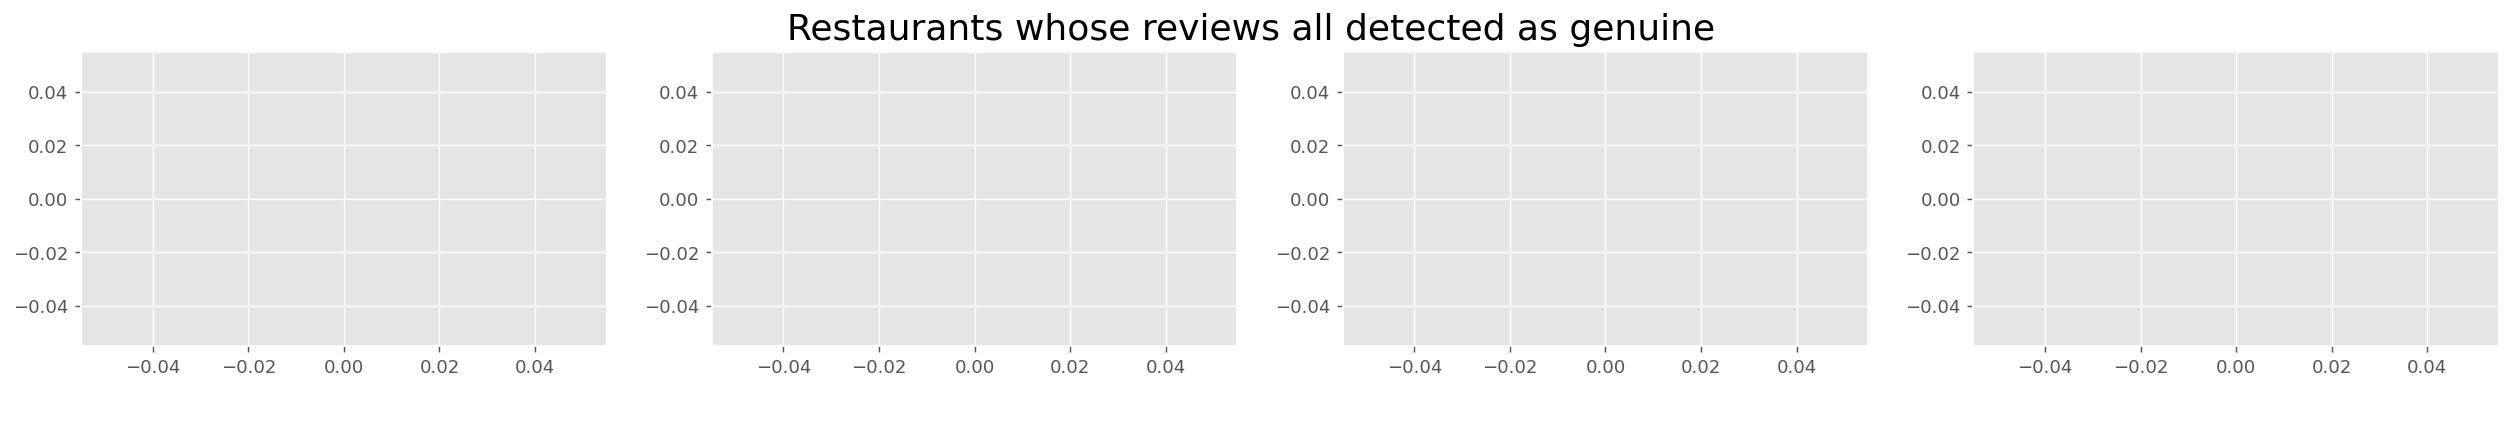

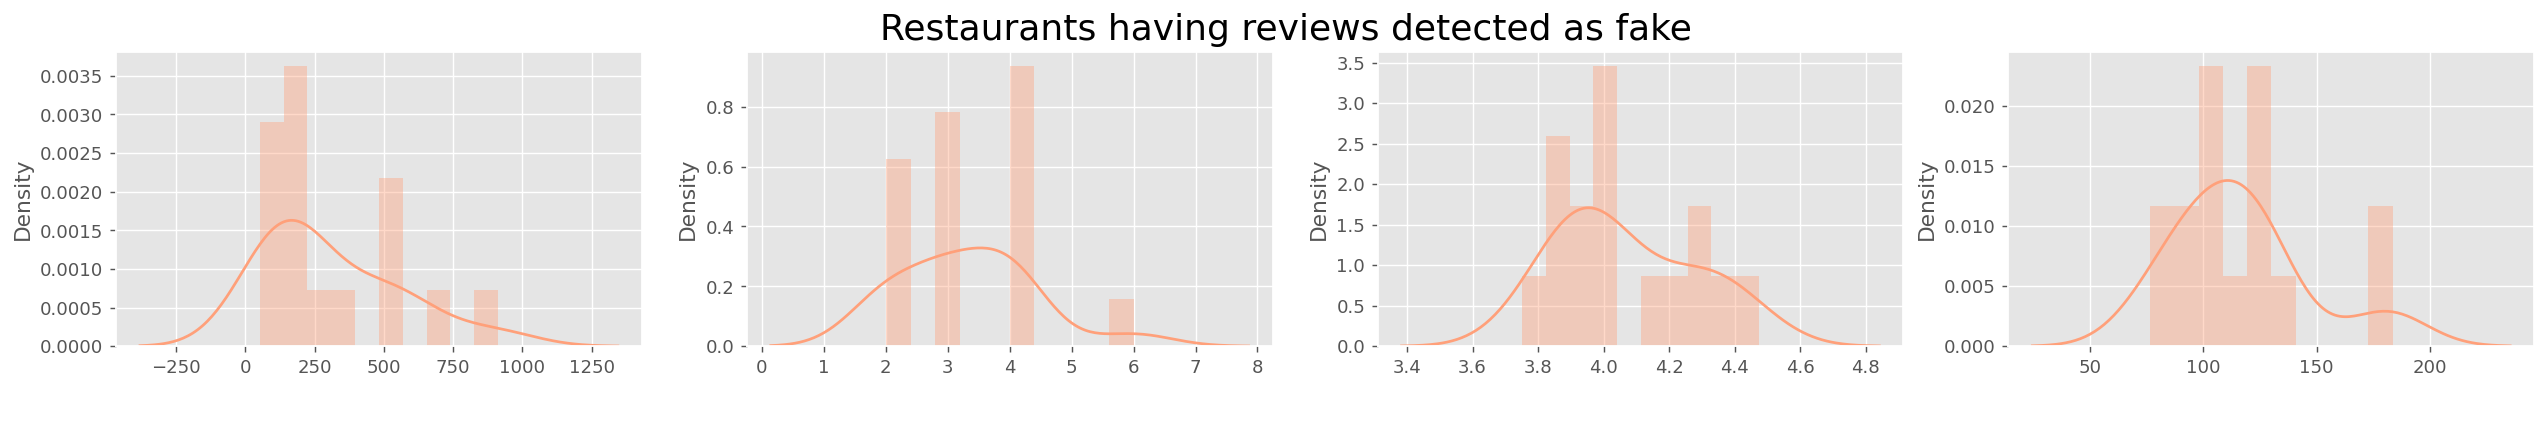

In [63]:
def displot_prod(df,color,title):
    plt.style.use('ggplot')
    #sns.set_style('darkgrid', {'figure.facecolor': 'black'})
    fig,axes=plt.subplots(1,4, figsize=(24, 3), dpi = 130)
    fig.suptitle(title, fontsize = 20)
    sns.distplot(df.prod_no_of_review, kde=True, bins=10,ax=axes[0],color=color)
    #axes[0].tick_params(colors='white') 
    axes[0].set_xlabel('Total number of reviews',fontsize = 16, color = 'white')
    sns.distplot(df.prod_max_no_review_per_day,kde= True, bins=10,ax=axes[1],color=color)
    #axes[1].tick_params(colors='white') 
    axes[1].set_xlabel('Max number of reviews received per day',fontsize = 16, color = 'white')
    sns.distplot(df.prod_avg_rating,kde=True,bins=10,ax=axes[2], color=color)
    #axes[2].tick_params(colors='white') 
    axes[2].set_xlabel('Average rating',fontsize = 16, color = 'white')
    sns.distplot(df.prod_avg_no_words,kde=True,bins=10,ax=axes[3],  color=color)
    #axes[3].tick_params(colors='white') 
    axes[3].set_xlabel('Avearage number of words',fontsize = 16, color = 'white')
    plt.show()

displot_prod(df_prod_genuine, "FireBrick", 'Restaurants whose reviews all detected as genuine')  
displot_prod(df_prod_fake, "lightsalmon", 'Restaurants having reviews detected as fake')     

# 4. Models

## 4.1 Data Pre-processing for Modeling

### 4.1.1 Drop Useless Columns

In [64]:
# Drop useless columns
df_model = df.drop(['User_id','Product_id','Review','review_text_token','Date'], axis=1)
df_model.fillna(value=0, inplace=True)

In [65]:
#df_model.info()
#df_model.describe()
df_model.head()

,Rating,Label,day_of_week,char_count,word_count,word_density,exclamation_percent,punctuation_percent,title_word_percent,upper_case_word_percent,...,user_avg_rating,user_rating_std,user_avg_no_words,user_has_dup_text,prod_no_of_review,prod_max_no_review_per_day,prod_avg_rating,prod_rating_std,prod_avg_no_words,prod_has_dup_text
0,3,-1,0,215,40,5.243902,0.0,0.150000,0.150000,0.000000,...,3.0,0.000000,40.0,0,210,2,4.009524,0.896514,89.266667,0
1,3,-1,3,269,52,5.075472,0.0,0.192308,0.115385,0.019231,...,3.0,0.000000,52.0,0,210,2,4.009524,0.896514,89.266667,0
2,4,-1,0,180,34,5.142857,0.0,0.147059,0.176471,0.088235,...,4.0,0.000000,34.0,0,210,2,4.009524,0.896514,89.266667,0
3,4,-1,3,493,92,5.301075,0.0,0.152174,0.097826,0.054348,...,4.0,0.000000,92.0,0,210,2,4.009524,0.896514,89.266667,0
4,4,-1,0,601,107,5.564815,0.0,0.168224,0.140187,0.056075,...,3.0,1.414214,114.0,0,210,2,4.009524,0.896514,89.266667,0


In [66]:
df_model[df_model.Label == 1].shape

(4403, 24)

### 4.1.2 Split Dataset

In [67]:
# Train-test split
from sklearn.model_selection import train_test_split
#train, test = train_test_split(df_model, test_size = 0.2, random_state = 42)
x,y=df_model,df_model['Label']
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)


In [68]:
X_train[X_train.Label == 1].shape

(3075, 24)

In [69]:
X_test.tail()

,Rating,Label,day_of_week,char_count,word_count,word_density,exclamation_percent,punctuation_percent,title_word_percent,upper_case_word_percent,...,user_avg_rating,user_rating_std,user_avg_no_words,user_has_dup_text,prod_no_of_review,prod_max_no_review_per_day,prod_avg_rating,prod_rating_std,prod_avg_no_words,prod_has_dup_text
2339,5,-1,0,594,104,5.657143,0.0,0.125000,0.125000,0.028846,...,5.0,0.0,104.0,0,547,4,4.032907,0.886826,100.853748,0
1835,4,-1,1,72,13,5.142857,0.0,0.000000,0.076923,0.000000,...,4.0,0.0,13.0,0,508,3,4.200787,0.905299,120.171260,1
4133,5,-1,3,847,173,4.867816,0.0,0.075145,0.150289,0.069364,...,5.0,0.0,173.0,0,498,4,4.473896,0.876889,95.702811,0
4436,4,1,5,808,154,5.212903,0.0,0.123377,0.110390,0.032468,...,4.0,0.0,154.0,0,498,4,4.473896,0.876889,95.702811,0
1146,5,1,6,703,126,5.535433,0.0,0.142857,0.111111,0.031746,...,5.0,0.0,126.0,0,913,4,4.313253,1.084384,178.751369,1


### 4.1.4 StandardScaler

In [70]:
# StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # train set: fit_transform
X_test_scaled = scaler.transform(X_test) # test set: transform

## 4.2 Modeling

### 4.2.1 AdaBoost

In [71]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC

#tuned_parameters_svm = [{'C': [0.01,0.1,1,10,100]}] 

# Find optimal parameters by GridSearchCV 
#svm_clf = SVC(kernel = 'rbf', probability=True, max_iter=2000, random_state = 42)
#svm_gs = GridSearchCV(svm_clf, tuned_parameters_svm,scoring = 'f1', cv=5)

#svm_gs.fit(X_train_scaled, y_train_RUS)
#print(svm_gs.best_estimator_)
#Adaboost
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
gs1 = GridSearchCV(
                    estimator=ABC, 
                    param_grid=param_grid, 
                    scoring = 'roc_auc')
print ('Fitting grid search...')
gs1.fit(X_train,y_train)
print ("Grid search fitted.")

Fitting grid search...
Grid search fitted.


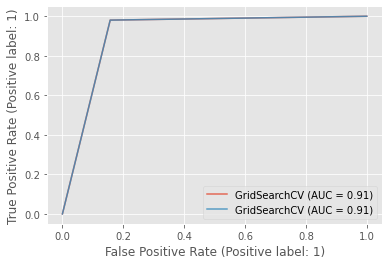

In [72]:
##best_svm = svm_gs.best_estimator_
#best_svm.fit(X_train_scaled, y_train_RUS)
#pred_svm = best_svm.predict(X_test_scaled)
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp = plot_roc_curve(gs1, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()

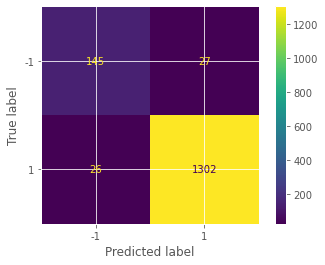

In [73]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

clf1 = gs1.best_estimator_

predicted1 = clf1.predict(X_test)
#print("Accuracy",accuracy_score(predicted1,y_test))
plot_confusion_matrix(clf1, X_test, y_test)

### 4.2.2 Logistics Regression

In [74]:
#from sklearn.linear_model import LogisticRegression

#uned_parameters_lr = [{'C': [0.001,0.01,0.1,1,10,100]}]

# Find optimal parameters by GridSearchCV 
#lr_clf = LogisticRegression(random_state = 42)
#lr_gs = GridSearchCV(lr_clf, tuned_parameters_lr, scoring = 'f1', cv=5)

#lr_gs.fit(X_train_scaled, y_train_RUS)
#print(lr_gs.best_estimator_)

#Logistic Regression
gs2 = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'C': [0.001,0.01,0.1,1,10,100], 'class_weight': [None, 'balanced']},
    cv=StratifiedKFold(n_splits=5),
    scoring='roc_auc'
)

#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train, y_train)
print ("Grid search fitted.")

Fitting grid search...
Grid search fitted.


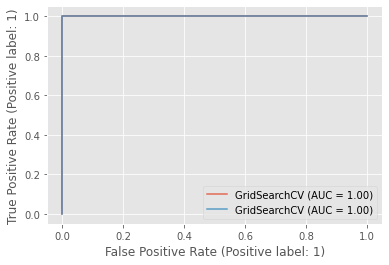

In [75]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp = plot_roc_curve(gs2, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [76]:
clf2=  gs2.best_estimator_


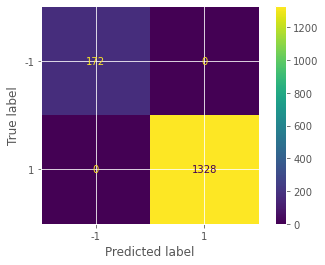

In [77]:
predicted2 = clf2.predict(X_test)
#print("Accuracy",accuracy_score(predicted2,y_test))
plot_confusion_matrix(clf2, X_test, y_test)


### 4.2.3 Random Forest

In [78]:
#from sklearn.ensemble import RandomForestClassifier

#tuned_parameters_rf = [{'n_estimators': range(94,97), 
 #                        'max_depth':range(2,8),
  #                       'min_samples_leaf': range(3,6)}]


# Find optimal parameters by GridSearchCV 
#rf_clf = RandomForestClassifier(oob_score = True, random_state = 42)
#rf_gs = GridSearchCV(rf_clf, tuned_parameters_rf, scoring = 'f1', cv=5)

#rf_gs.fit(X_train_scaled, y_train_RUS)
#print(rf_gs.best_estimator_)

#RandomForest
param_grid = {
'bootstrap': [True],
'max_depth': [80, 90, 100, 110],
'max_features': [2,3],
'min_samples_leaf': [2,3,4],
'min_samples_split': [2, 5, 10],
'n_estimators': [100, 200, 300, 1000]
}

gs3 = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=2),
    scoring='roc_auc',
    n_jobs = -1, 
    verbose = 2
)

print ('Fitting grid search...')
gs3.fit(X_train,y_train)
print ("Grid search fitted.")

Fitting grid search...
Fitting 2 folds for each of 288 candidates, totalling 576 fits
Grid search fitted.


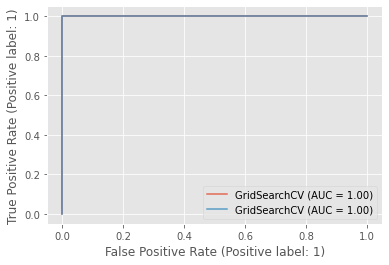

In [79]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp = plot_roc_curve(gs3, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()


In [80]:
clf3=  gs3.best_estimator_

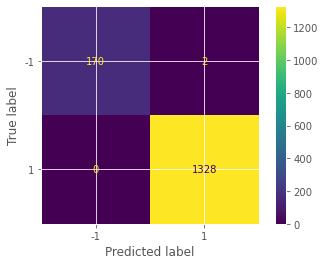

In [81]:
predicted3 = clf3.predict(X_test)
#print("Accuracy",accuracy_score(predicted3,y_test))
plot_confusion_matrix(clf3, X_test, y_test)

In [82]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

In [83]:
def models_evaluation(X, y, folds):
    aB = cross_validate(clf1, X, y, cv=folds, scoring=scoring)
    lR = cross_validate(clf2, X, y, cv=folds, scoring=scoring)
    RF = cross_validate(clf3, X, y, cv=folds, scoring=scoring)

    

    # Create a data frame with the models performance metrics scores
    models_scores_table = pd.DataFrame({'AdaBoost':[aB['test_accuracy'].mean(),
                                                               aB['test_precision'].mean(),
                                                               aB['test_recall'].mean(),
                                                               aB['test_f1_score'].mean()],

                                      'Logistic Regression':[lR['test_accuracy'].mean(),
                                                                   lR['test_precision'].mean(),
                                                                   lR['test_recall'].mean(),
                                                                   lR['test_f1_score'].mean()],

                                      'Random Forest':[RF['test_accuracy'].mean(),
                                                       RF['test_precision'].mean(),
                                                       RF['test_recall'].mean(),
                                                       RF['test_f1_score'].mean()]
                                        
                                      

                                                       
                                                       },


                                      

                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    return(models_scores_table)
models_evaluation(x, y, 3)

,AdaBoost,Logistic Regression,Random Forest,Best Score
Accuracy,0.997399,0.999800,0.995000,Logistic Regression
Precision,0.999089,0.999773,0.994383,Logistic Regression
Recall,0.997956,1.000000,1.000000,Logistic Regression
F1 Score,0.998521,0.999886,0.997176,Logistic Regression


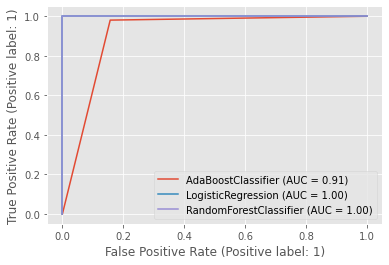

In [84]:
disp=plot_roc_curve(clf1, X_test,y_test)
plot_roc_curve(clf2, X_test,y_test,ax=disp.ax_)
plot_roc_curve(clf3, X_test,y_test,ax=disp.ax_)